# Water Body Segmentation - PyTorch

This notebook contains the code for training a UNET model using PyTorch for image segmentation of satellite images into water bodies and non water bodies

## Importing Libraries

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Setting the seed for reproducibility

In [2]:
seed = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(seed)

## Loading the Dataset

The dataset contains 2841 instances of satellite images of water bodies and their mask of dimensions 256 * 256.

For the purpose of training the model we load the image and mask using openCV and convert the image to RGB format and the mask to gray scale.
Then all the values in the image and mask are divided by 255 to make them in the range of [0, 1]. After this augmentation is applied to both of them and converted to PyTorch Tensor.
In the case of the image the we applya permutation after converting to change it from the `HxWxC` to `CxHxW` which PyTorch uses and for the mask we also add another dimension in the front for the channel using `unsqueeze()` functions since it has only `HxW` dimeansions before returning them.

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, image_folder, mask_folder, transform=None):
        self.images = images
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.images[idx])
        mask_path = os.path.join(self.mask_folder, self.images[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = np.array(image, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.float32) / 255.0
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
#         return torch.from_numpy(image).permute(2, 0, 1), torch.from_numpy(mask).unsqueeze(0)
        
        image = torch.from_numpy(image).permute(2, 0, 1)
        image = torchvision.transforms.functional.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        mask = torch.from_numpy(mask).unsqueeze(0)
        return image, mask

The data is split in the ratio of train_images = 0.8, val_images = 0.1 and test_images = 0.1 using sklearns `test_train_split` function.

In [27]:
base_path = 'D:/OneDrive - The University of Nottingham/Dissertation/Data/Water Bodies Dataset/'
image_folder = os.path.join(base_path, 'Images')
mask_folder = os.path.join(base_path, 'Masks')

images = os.listdir(image_folder)

train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
test_images, val_images = train_test_split(test_images, test_size=0.5, random_state=42)

<BarContainer object of 3 artists>

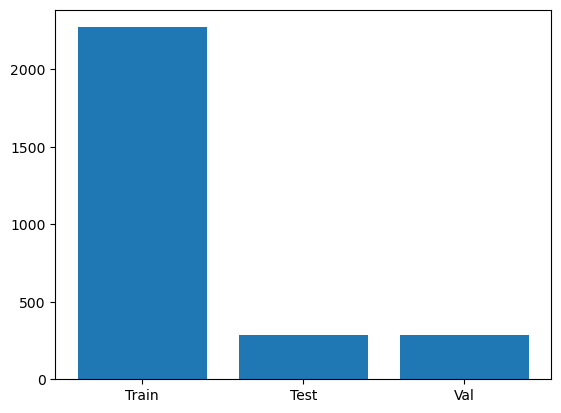

In [28]:
dataset_sizes = [len(train_images), len(test_images), len(val_images)]
labels = ["Train", "Test", "Val"]

plt.bar(labels, dataset_sizes)

In [29]:
train_transform = A.Compose([A.Resize(256, 256), A.HorizontalFlip(p= 0.5), A.VerticalFlip(p= 0.5), A.RandomRotate90(p= 0.5)])
val_transform = A.Compose([A.Resize(256, 256), A.HorizontalFlip(p= 0.5), A.VerticalFlip(p= 0.5), A.RandomRotate90(p= 0.5)])
test_transform = A.Compose([A.Resize(256, 256)])

trainset = Dataset(train_images, image_folder, mask_folder, transform= train_transform)
testset = Dataset(test_images, image_folder, mask_folder, transform= test_transform)
valset = Dataset(val_images, image_folder, mask_folder, transform= val_transform)

train_batch_size = 32
val_batch_size = 32
test_batch_size = 8

trainloader = torch.utils.data.DataLoader(trainset, batch_size= train_batch_size, num_workers= 0, shuffle= True)
valloader = torch.utils.data.DataLoader(valset, batch_size= val_batch_size, num_workers= 0, shuffle= True)
testloader = torch.utils.data.DataLoader(testset, batch_size= test_batch_size, num_workers= 0, shuffle= True)

## Designing the U-NET model

In [18]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                                    nn.Conv2d(in_channels, in_channels // 2, 1))
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.conv(x))

In [19]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x4, x3)
        x = self.up3(x3, x2)
        x = self.up4(x2, x1)
        logits = self.outc(x)
        return logits

## Loss function

For Loss function we take the sum of BCE and DICE loss. DICE coefficient is calculate using the formula `(2 * area of overlap) / total number of pixels combines`.

DICE loss can be calculated using `1 - DICE coefficient`   

In [17]:
class DICE_BCE_Loss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        intersection = 2*(logits * targets).sum() + self.smooth
        union = (logits + targets).sum() + self.smooth
        dice_loss = 1. - intersection / union

        loss = nn.BCELoss()
        bce_loss = loss(logits, targets)

        return dice_loss + bce_loss
    
def dice_coeff(logits, targets):
    intersection = 2*(logits * targets).sum()
    union = (logits + targets).sum()
    if union == 0:
        return 1
    dice_coeff = intersection / union
    return dice_coeff.item()

## Train Function

In [10]:
def train(model, trainloader, optimizer, loss, epochs=10):
    train_losses, val_losses = [], []
    train_dices, val_dices = [], []
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        train_dice = 0
        for i, (images, masks) in enumerate(trainloader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            logits = model(images)
            l = loss(logits, masks)
            l.backward()
            optimizer.step()
            train_loss += l.item()
            train_dice += dice_coeff(logits, masks)
        train_loss /= len(trainloader)
        train_dice /= len(trainloader)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        
        #Validation
        model.eval()
        val_loss = 0
        val_dice = 0
        with torch.no_grad():
            for i, (images, masks) in enumerate(valloader):
                images, masks = images.to(device), masks.to(device)
                logits = model(images)
                l = loss(logits, masks)
                val_loss += l.item()
                val_dice += dice_coeff(logits, masks)
        val_loss /= len(valloader)
        val_dice /= len(valloader)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        print(f"Epoch: {epoch + 1}  Train Loss: {train_loss:.4f} | Train DICE Coeff: {train_dice:.4f} | Val Loss: {val_loss:.4f} | Val DICE Coeff: {val_dice:.4f}")
        
    return train_losses, train_dices, val_losses, val_dices

## Hyperparameters and Training

We train the model for 30 epochs and the optimizer used is ADAM as it gives good accuracy and is relatively faster.

In [23]:
epochs = 30
loss = DICE_BCE_Loss()
model = UNet(3, 1).to(device)
weights_path = 'water_bodies_model.pth'
weights_dict = torch.load(weights_path, map_location='cpu')
model.load_state_dict(weights_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, train_dices, val_losses, val_dices = train(model, trainloader, optimizer, loss, epochs)

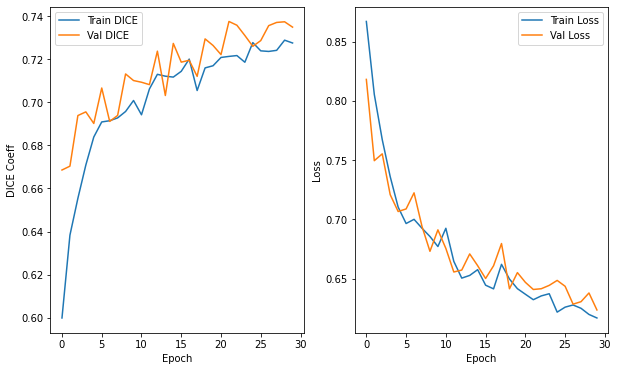

In [12]:
plt.figure(figsize= (10, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), train_dices)
plt.plot(np.arange(epochs), val_dices)
plt.xlabel("Epoch")
plt.ylabel("DICE Coeff")
plt.legend(["Train DICE", "Val DICE"])
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), train_losses)
plt.plot(np.arange(epochs), val_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Val Loss"])

## Testing the Model

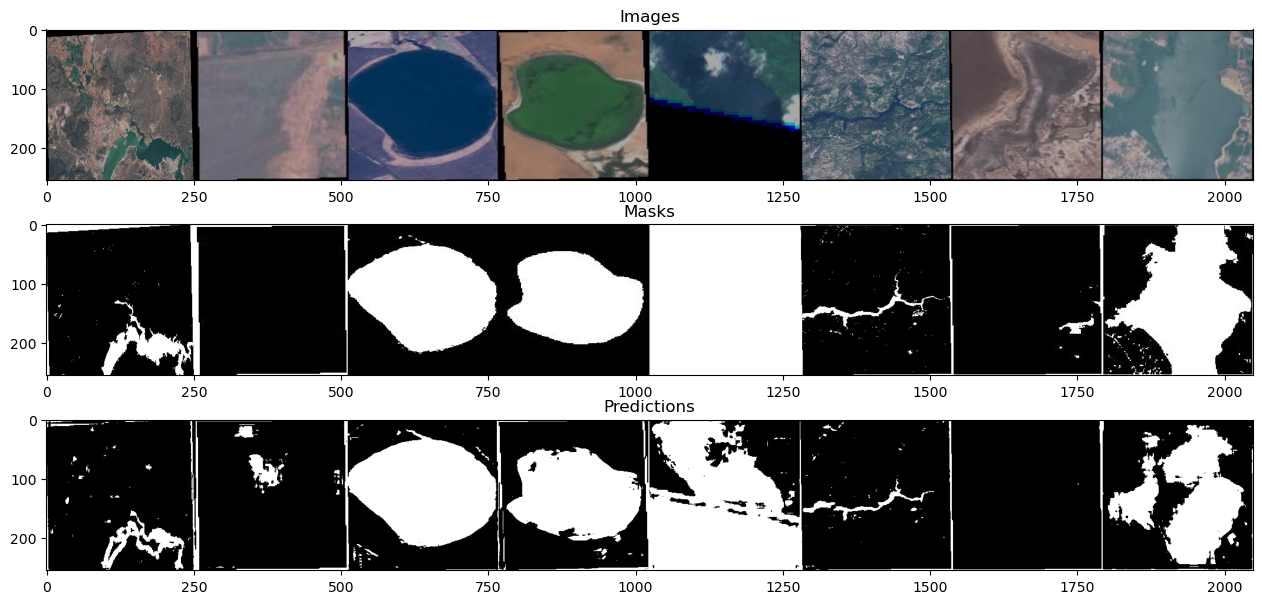

In [30]:
images, masks = next(iter(testloader))
with torch.no_grad():
    pred = model(images.to(device)).cpu().detach()
    pred = pred > 0.5

def denormalise(images):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    return images

def display_batch(images, masks, pred):
    images = denormalise(images)
    images = images.permute(0, 2, 3, 1)
    masks = masks.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)

    images = images.numpy()
    masks = masks.numpy()
    pred = pred.numpy()

    images = np.concatenate(images, axis=1)
    masks = np.concatenate(masks, axis=1)
    pred = np.concatenate(pred, axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(20, 6))
    fig.tight_layout()
    ax[0].imshow(images)
    ax[0].set_title('Images')
    ax[1].imshow(masks, cmap= 'gray')
    ax[1].set_title('Masks')
    ax[2].imshow(pred, cmap= 'gray')
    ax[2].set_title('Predictions')

display_batch(images, masks, pred)

## Saving the Model

The state dict of the PyTorch model can be saved using the `torch.save()` method.

In [14]:
torch.save(model.state_dict(), 'water_bodies_model.pth')

We can use IPython library to create a downloadable link for the state dict.

In [15]:
from IPython.display import FileLink
FileLink(r'water_bodies_model.pth')


/kaggle/working/water_bodies_model.pth